In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1.0 Loading Video and Image

In [2]:

def read_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if not cap.isOpened():
        return None

    frames = [] 
    while True:
        ret, frame = cap.read()
        if not ret:
            break  
        
        frames.append(frame) 

    cap.release()

    
    frames = np.array(frames) 

    return frames,fps

In [3]:
book_frames,book_fps = read_video_frames("book.mov")

In [4]:
movie_frames,panda_fps = read_video_frames("ar_source.mov")

In [5]:
book_front=cv2.imread("cv_cover.jpg")

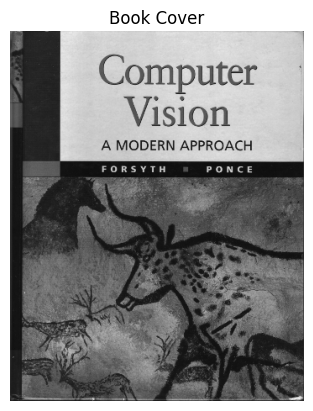

In [6]:
plt.imshow(book_front)
plt.axis('off')  
plt.title("Book Cover")
plt.show()

In [7]:
print(f"Frames in Book Video : {len(book_frames)}")
print(f"Frames in Movie Video : {len(movie_frames)}")

Frames in Book Video : 641
Frames in Movie Video : 511


## 1.1 Get Correspondences

In [8]:
def get_keypoints_SIFT(img):
    """
    returns keypoints, descriptor and image overlayed with keypoints
    """
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(gray, None)
    img=cv2.drawKeypoints(img,kp,0)
    return kp,desc ,img
 

In [9]:
key_points_book,desc_book,im_new_1 = get_keypoints_SIFT(book_front)
first_frame_key_points,desc_video,im_new_2= get_keypoints_SIFT(book_frames[0])

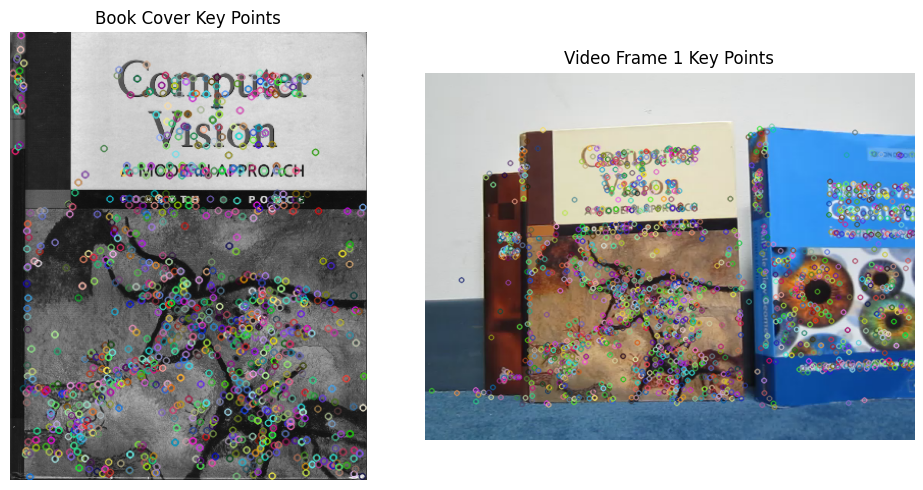

In [10]:
plt.figure(figsize=(10, 5)) 

plt.subplot(1, 2, 1) 
plt.imshow(im_new_1)
plt.title("Book Cover Key Points")
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im_new_2,cv2.COLOR_BGR2RGB))
plt.title("Video Frame 1 Key Points")
plt.axis('off')


plt.tight_layout()  
plt.show()

In [11]:
def get_matches(img1_desc,img2_desc,number_of_matches):
    
    brute_force_matching = cv2.BFMatcher()
    matches_detected = brute_force_matching.knnMatch(img1_desc,img2_desc,k=2)
    ratios = []
    for (i,j) in matches_detected:
      ratios.append((i, i.distance/j.distance))
    #sort matches by ratios 
    ratios = sorted(ratios,key=lambda x:x[1])[0:number_of_matches]
    final_matches = [x[0] for x in ratios]
    final_matches = sorted(final_matches, key=lambda x:x.distance)
    return final_matches

In [12]:
correspondences= get_matches(desc_book,desc_video,50)
print(len(correspondences))

50


In [13]:
#draw coreespondances
matched_img = cv2.drawMatches(book_front, key_points_book, cv2.cvtColor(book_frames[0],cv2.COLOR_BGR2RGB), first_frame_key_points, correspondences, 0, flags=2)

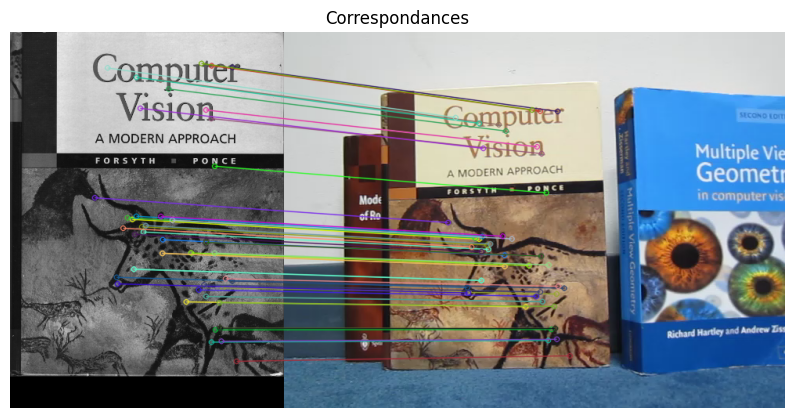

In [14]:
plt.figure(figsize=(10, 5)) 
plt.imshow(matched_img)
plt.axis('off')  
plt.title("Correspondances")
plt.show()

## 1.2 Compute the Homography Parameters

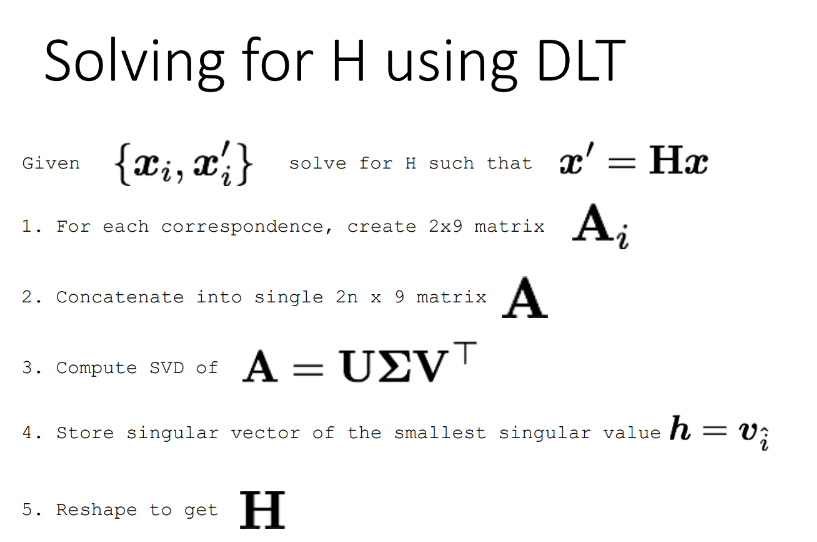

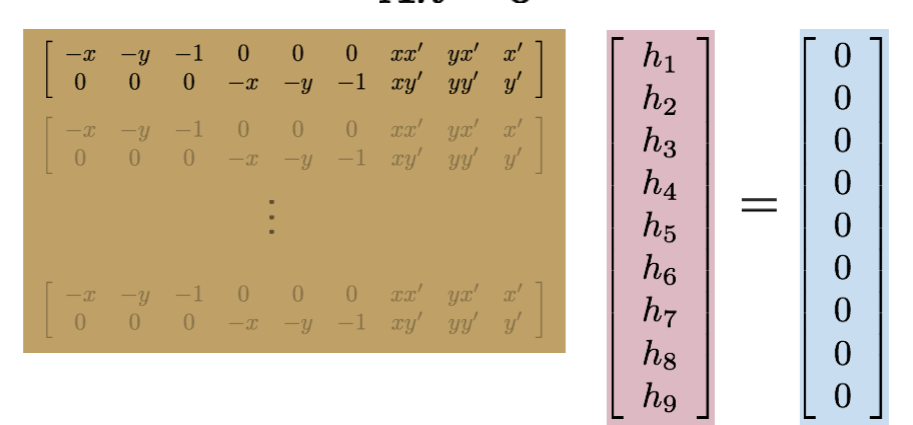

In [15]:
def compute_homography(p,p_dash):
    if (not len(p) == len(p_dash)) or len(p) < 4:
        return None
    n = len(p)
    A = np.zeros((2*n,9))
    for i in range(0,n*2,2):
        (x,y) = p[i//2]
        (x_dash,y_dash) = p_dash[i//2]
        A[i] = np.array([-1*x,-1*y,-1,0,0,0,x*x_dash,y*x_dash,x_dash])
        A[i+1] = np.array([0,0,0,-1*x,-1*y,-1,x*y_dash,y*y_dash,y_dash])

    u, sigma, vt = np.linalg.svd(A)

    H = vt[-1,:]/vt[-1,-1]
    H= H.reshape(3,3)
    return H

In [16]:
p = np.array([key_points_book[m.queryIdx].pt for m in correspondences]) 
p_dash = np.array([first_frame_key_points[m.trainIdx].pt for m in correspondences])

In [17]:
H = compute_homography(p,p_dash)

In [18]:
print(H)

[[ 7.73778320e-01  3.30955593e-03  1.19459841e+02]
 [-5.23431672e-02  7.78790167e-01  7.79037372e+01]
 [-9.05627058e-05 -7.40099004e-05  1.00000000e+00]]


In [19]:
H_built_in, _ = cv2.findHomography(p, p_dash, cv2.RANSAC)
print("H using built-in function:")
print(H_built_in)

H using built-in function:
[[ 7.74999682e-01  3.44772870e-03  1.19349922e+02]
 [-5.16607084e-02  7.79409929e-01  7.77740349e+01]
 [-8.81834885e-05 -7.36163252e-05  1.00000000e+00]]


Error between built in and calculated homography matrix is very acceptable

In [20]:
def transform_points(points, H):
    new_points = []
    for original_point in points:

        point = np.hstack((original_point, [1]))  # Append 1 for homogeneous
        point = point[..., np.newaxis] 
        new_point = H @ point  
        new_point = new_point / new_point[-1]  # Normalize to make homogeneous coordinate 1
        new_points.append(new_point.T) 
    new_points = np.array(new_points)[:, :, 0:2]
    new_points = new_points.squeeze()
    return new_points


In [21]:
def draw_points(image, points, color=(0, 255, 0)):
    copy_image = image.copy()
    for point in points:
        x, y = np.round(point).astype('int')
        cv2.circle(copy_image, (x, y), radius=5, color=color, thickness=-1)
    return copy_image



### Verification of homography features

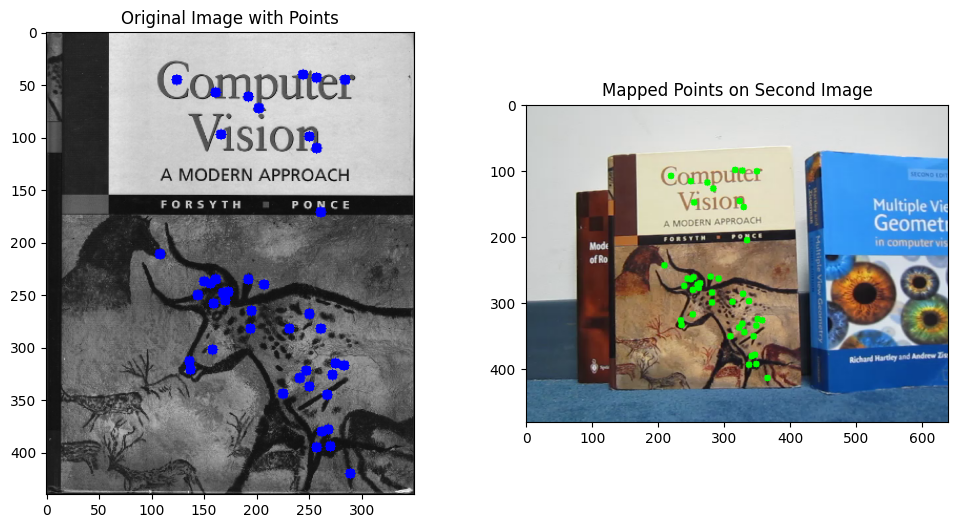

In [22]:
#matching features from one point to another
mapped_points = transform_points(p, H)

image1_with_points = draw_points(book_front, p, color=(255, 0, 0)) 
image2_with_mapped_points = draw_points(book_frames[0], mapped_points, color=(0, 255, 0)) 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_with_points, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Points")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_with_mapped_points, cv2.COLOR_BGR2RGB))
plt.title("Mapped Points on Second Image")
plt.show()

This verify that the homography is good the features clicked in the cover are found accurately in the first frame of the video

## 1.3 Calculate Book Coordinates

In [23]:
#get corners of book and transform them to first frame
height, width,_ = book_front.shape
corners = np.array([[0,0],[0,height-1],[width-1,height-1],[width-1,0]])
transformed_corners = transform_points(corners,H)

In [24]:
book_projection = cv2.polylines(book_frames[0].copy(), [np.int32(transformed_corners)], True, 255, 3, cv2.LINE_AA)

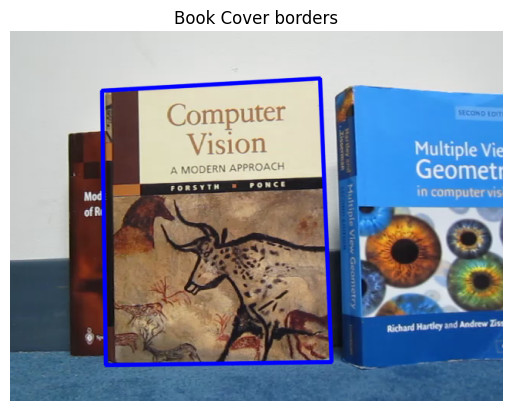

In [25]:
plt.imshow(cv2.cvtColor(book_projection, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title("Book Cover borders")
plt.show()

## 1.4 Crop AR Video Frames

In [26]:
def crop_frame(frame, target_width, target_height):
    
    frame_height, frame_width, _ = frame.shape
    cropped = frame[44:-44, (frame_width // 3): ((frame_width * 2) // 3)]
    cropped_frame = cv2.resize(cropped, (target_width,target_height))

    return cropped_frame

In [27]:
cropped_frame = crop_frame(movie_frames[0].copy(), width, height)

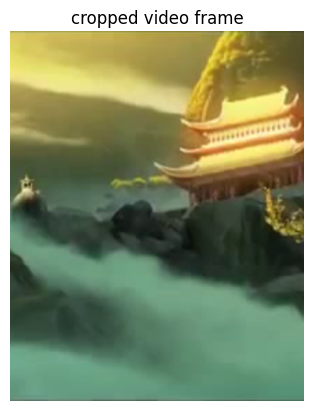

In [28]:
plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title("cropped video frame")
plt.show()

## 1.5 Overlay Video

In [29]:
def overlay(book_frame, movie_frame, H):
    height, width,_ = book_front.shape
    book_corners = np.array([[0,0],[0,height-1],[width-1,height-1],[width-1,0]])

    transformed_corners = transform_points(np.array([book_corners]), H)


    x_min, y_min = np.min(transformed_corners, axis=0).astype(int)
    x_max, y_max = np.max(transformed_corners, axis=0).astype(int)

    movie_cropped = crop_frame(movie_frame.copy(), width, height)

    mask = np.zeros_like(book_frame)
    mask[y_min:y_max, x_min:x_max] = movie_cropped

    result = book_frame.copy()
    result[y_min:y_max, x_min:x_max] = mask[y_min:y_max, x_min:x_max]

    return result


In [30]:
h, w, _ = book_frames[0].shape

overlayed = book_frames[0].copy()
overlayed = cv2.warpPerspective(cropped_frame, H, (w, h), dst=overlayed, borderMode=cv2.BORDER_TRANSPARENT)


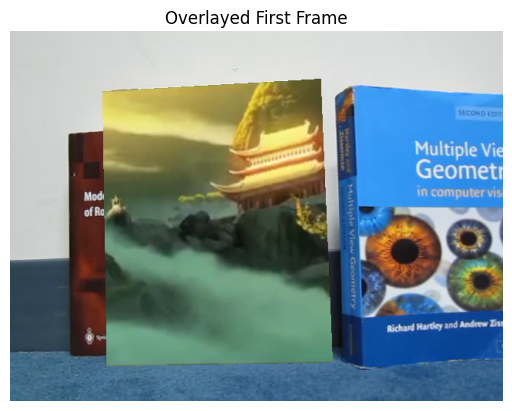

In [31]:
plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title("Overlayed First Frame")
plt.show()

In [32]:
vid_frames = []
key_points_book,desc_book,im_new_1 = get_keypoints_SIFT(book_front)

for i in range(len(movie_frames)):
    book_frame_key_points,desc_video,im_new_2= get_keypoints_SIFT(book_frames[i])
    correspondences= get_matches(desc_book,desc_video,50)
    P = np.array([key_points_book[m.queryIdx].pt for m in correspondences])
    P_dash = np.array([book_frame_key_points[m.trainIdx].pt for m in correspondences])
    height, width,_ = book_front.shape
    H = compute_homography(P,P_dash)

    corners = np.array([[0,0],[0,height-1],[width-1,height-1],[width-1,0]])

    transformed_corners = transform_points(corners,H)
    cropped_frame = crop_frame(movie_frames[i].copy(), width, height)

    h, w, _ = book_frames[i].shape

    overlayed = book_frames[i].copy()
    overlayed = cv2.warpPerspective(cropped_frame, H, (w, h), dst=overlayed, borderMode=cv2.BORDER_TRANSPARENT)
    vid_frames.append(overlayed)

## 1.6 Save Output Video

In [33]:
height, width, _ = vid_frames[0].shape 

fourcc = cv2.VideoWriter_fourcc(*'MP4V')  
output_video = 'output1.mov'  

out = cv2.VideoWriter(output_video, fourcc, book_fps, (width, height))

for frame in vid_frames:
    out.write(frame)

out.release()